## HW 2: Crossentropy method
_Reference: based on Practical RL course by YSDA_

In this notebook you have to solve two simple RL problems with crossentropy method.

To get used to `gymnasium` package, please, refer to the [documentation](https://gymnasium.farama.org/introduction/basic_usage/).


In the end of the notebook, please, copy the functions you have implemented to file `template_crossentropy.py` and submit it to the Contest.

In [14]:
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import pandas as pd
%matplotlib inline

## Part 1. Tabular CrossEntropy
Let's consider discrete game "Taxi".

There are four designated pick-up and drop-off locations (Red, Green, Yellow and Blue) in the 5x5 grid world. The taxi starts off at a random square and the passenger at one of the designated locations.

The goal is move the taxi to the passenger’s location, pick up the passenger, move to the passenger’s desired destination, and drop off the passenger. Once the passenger is dropped off, the episode ends.

The player receives positive rewards for successfully dropping-off the passenger at the correct location. Negative rewards for incorrect attempts to pick-up/drop-off passenger and for each step where another reward is not received.

You can find full description of the environment [here](https://gymnasium.farama.org/environments/toy_text/taxi/).

![Taxi-v3](https://gymnasium.farama.org/_images/taxi.gif)

So here's how it works:

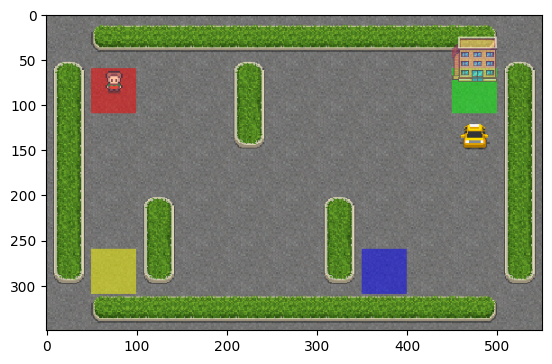

In [15]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()

plt.imshow(env.render())

In [16]:
env.close()

In [17]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i" % (n_states, n_actions))

n_states=500, n_actions=6


Let's make an action 1 and see what happens:

In [9]:
next_state, reward, is_done, _, _ = env.step(1)

In [10]:
print(f"We got to state {next_state}, the reward is {reward}, game is not finished because is_done={is_done}")

We got to state 273, the reward is -1, game is not finished because is_done=False


### Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


In [12]:
policy = np.ones((n_states, n_actions)) / n_actions

In [13]:
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

In [18]:
policy

array([[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       ...,
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667]])

### Play the game

Just like before, but we also record all states and actions we took.

Sample the action (e.g. `np.random.choice()`) from available actions and make a step in the environment using `env.step()`.

In [19]:
def generate_session(env, policy, t_max=int(10**4)):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.

    s, info = env.reset()

    for t in range(t_max):
        # your code here - sample action from policy and get new state, reward, done flag etc. from the environment
        a = np.random.choice(env.action_space.n, p=policy[s])
        new_s, r, done, truncated, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r
        assert new_s is not None and r is not None and done is not None
        assert a is not None

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [20]:
s, a, r = generate_session(env=env, policy=policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float, np.float64]

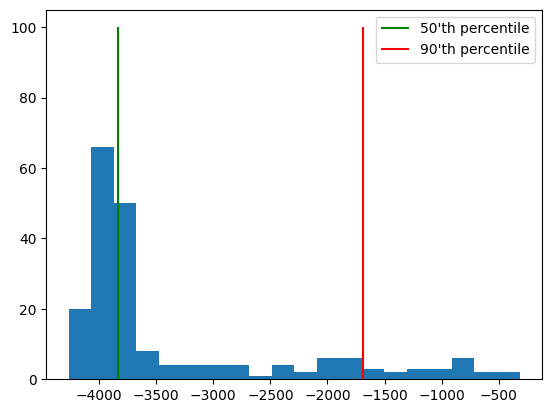

In [21]:
# let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(env=env, policy=policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

In [22]:
np.percentile(sample_rewards, 50)

np.float64(-3830.5)

### Crossentropy method steps

In [27]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    elite_states = []
    elite_actions = []
    perc = np.percentile(rewards_batch, percentile)

    for i in range(len(rewards_batch)):
      if rewards_batch[i] >= perc:
          elite_states.extend(states_batch[i])
          elite_actions.extend(actions_batch[i])

    return elite_states, elite_actions

In [28]:
states_batch = [
    [1, 2, 3],     # game1
    [4, 2, 0, 2],  # game2
    [3, 1],        # game3
]

actions_batch = [
    [0, 2, 4],     # game1
    [3, 2, 0, 1],  # game2
    [3, 3],        # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=0)
test_result_40 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
    and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
    "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
    np.all(test_result_40[1] == [3, 2, 0, 1, 3, 3]),\
    "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and \
    np.all(test_result_90[1] == [3, 3]),\
    "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and\
    np.all(test_result_100[1] == [3, 3]),\
    "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [29]:
def update_policy(elite_states, elite_actions, n_states=n_states, n_actions=n_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to

    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]

    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """
    new_policy = np.zeros((n_states, n_actions))
    for s, a in zip(elite_states, elite_actions):
      new_policy[s, a] += 1

    for s in range(n_states):
      if np.sum(new_policy[s]) == 0:
        new_policy[s] = [1/n_actions]*n_actions
      else:
        new_policy[s] /= np.sum(new_policy[s])

    return new_policy

In [30]:
elite_states = [1, 2, 3, 4, 2, 0, 2, 3, 1]
elite_actions = [0, 2, 4, 3, 2, 0, 1, 3, 3]

new_policy = update_policy(elite_states, elite_actions)

assert np.isfinite(new_policy).all(
), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(
    new_policy >= 0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(
    axis=-1), 1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
    [1.,  0.,  0.,  0.,  0.],
    [0.5,  0.,  0.,  0.5,  0.],
    [0.,  0.33333333,  0.66666667,  0.,  0.],
    [0.,  0.,  0.,  0.5,  0.5]])
assert np.allclose(new_policy[:4, :5], reference_answer)
print("Ok!")

Ok!


### Training loop
Generate sessions, select N best and fit to those.

In [31]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [32]:
# reset policy just in case
policy = np.ones([n_states, n_actions]) / n_actions

mean reward = -42.060, threshold=-26.500


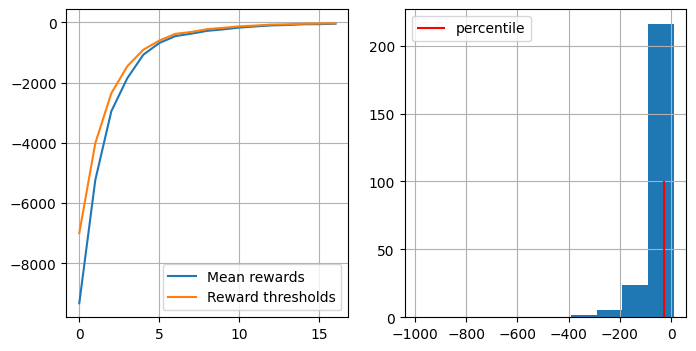

You Win!


In [36]:
n_sessions = 250  # sample this many sessions
percentile = 50  # take this percent of session with highest rewards
learning_rate = 0.5  # add this thing to all counts for stability

log = []

for i in range(100):

    %time sessions = [generate_session(env, policy) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    new_policy = update_policy(elite_states, elite_actions)

    policy = learning_rate*new_policy + (1-learning_rate)*policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)
    if np.mean(rewards_batch) > -50:
        print("You Win!")
        break

Congratulations! You've just trained your first RL model!
Now copy functions from this notebook to `template_crossentropy.py` and submit it to the Contest problem `Tabular CrossEntropy`.

## Part 2: Approximate crossentropy and neural nets.

In this section you will train a neural network policy for continuous state space game

You can find full description of the environment [here](https://www.gymlibrary.dev/environments/classic_control/cart_pole/).

![CartPole-v0"](https://www.gymlibrary.dev/_images/cart_pole.gif)

So here's how it works:

In [37]:
# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n

/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


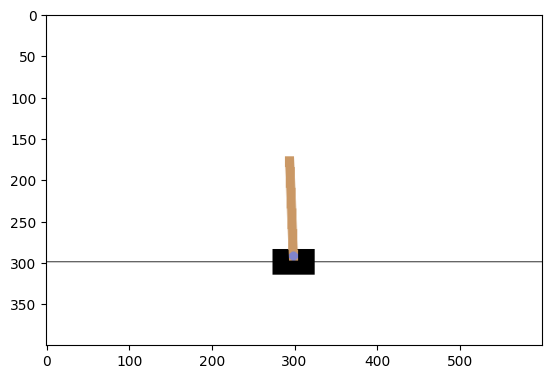

In [38]:
plt.imshow(env.render())

It is fine to use sklearn for such simple network, but we recommend you write the solution with PyTorch ;)

In [66]:
# create agent
from sklearn.neural_network import MLPClassifier

# YOUR CODE GOES HERE: implement your own agent
agent = MLPClassifier(hidden_layer_sizes=(20, 20),
                      activation='relu',
                      solver='adam',
                      learning_rate_init=0.001,
                      max_iter=1000)

# initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()[0]]*n_actions, range(n_actions))

MLPClassifier(hidden_layer_sizes=(20, 20), max_iter=1000)

Update the generate_session function and beat the game!

In [67]:
def generate_session_cartpole(t_max=300):

    states, actions = [], []
    total_reward = 0

    s, info = env.reset()

    for t in range(t_max):
        a = agent.predict([s])[0]
        new_s, r, done, truncated, info = env.step(a)

        # record sessions like you did before

        states.append(s.astype(dtype="object"))
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

mean reward = 216.680, threshold=281.000


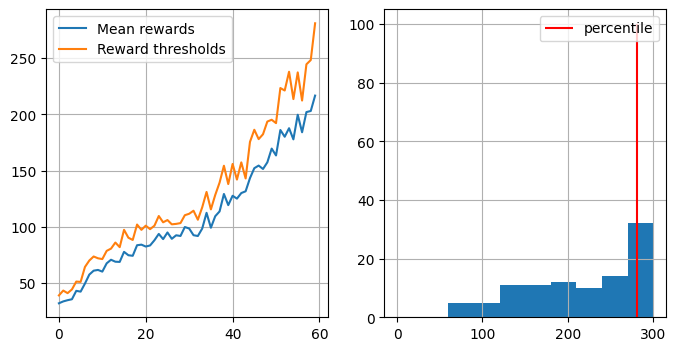

You Win!


In [68]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session_cartpole() for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.fit(elite_states, elite_actions)

    if max(rewards_batch) > min(rewards_batch):
        show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 210:
        print("You Win!")
        break

### Submission generation
To generate submission run the following block of code and submit the generated file to the contest problem `CrossEntropy CartPole`.

In [55]:
# DO NOT CHANGE THIS BLOCK
sessions = [generate_session_cartpole() for _ in range(n_sessions)]
states_batch, actions_batch, rewards_batch = zip(*sessions)
elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

sessions_to_send = []
for session in sessions:
  observations = [x.tolist() for x in session[0]]
  actions = [x.item() for x in session[1]]
  sessions_to_send.append((observations, actions))

import json
with open('sessions_to_send.json', 'w') as iofile:
  json.dump(sessions_to_send, iofile, ensure_ascii=True, indent=4)
# DO NOT CHANGE THIS BLOCK